In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('final_daily_stocks_cleaned.csv')

# Print basic info
print("Dataset Info:")
print(df.info())

# Show first few rows
print("\nFirst 5 Rows:")
print(df.head())

# Summary statistics
print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44242 entries, 0 to 44241
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     44220 non-null  object
 1   Open     44242 non-null  object
 2   High     44242 non-null  object
 3   Low      44242 non-null  object
 4   Close    44242 non-null  object
 5   Volume   44242 non-null  object
 6   ticker   44220 non-null  object
 7   company  44220 non-null  object
dtypes: object(8)
memory usage: 2.7+ MB
None

First 5 Rows:
         Date                Open                High                Low  \
0  2017-03-29  33.373452477074316   33.56159923128349  33.25963937410427   
1  2017-03-30   33.49190882568726   33.56391388701477  33.33163766634339   
2  2017-03-31    33.3827447550176  33.510497408339084  33.21782704904723   
3  2017-04-03   33.38041493515435   33.47564548544359  33.22711178943953   
4  2017-04-04   33.27357180868976  33.654504705427456  33.2549892839

In [3]:
# Drop rows with any missing values
df_cleaned = df.dropna()

# Confirm the result
print("After dropping missing values:")
print(df_cleaned.isnull().sum())
print(f"New shape of dataset: {df_cleaned.shape}")

After dropping missing values:
Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
ticker     0
company    0
dtype: int64
New shape of dataset: (44220, 8)


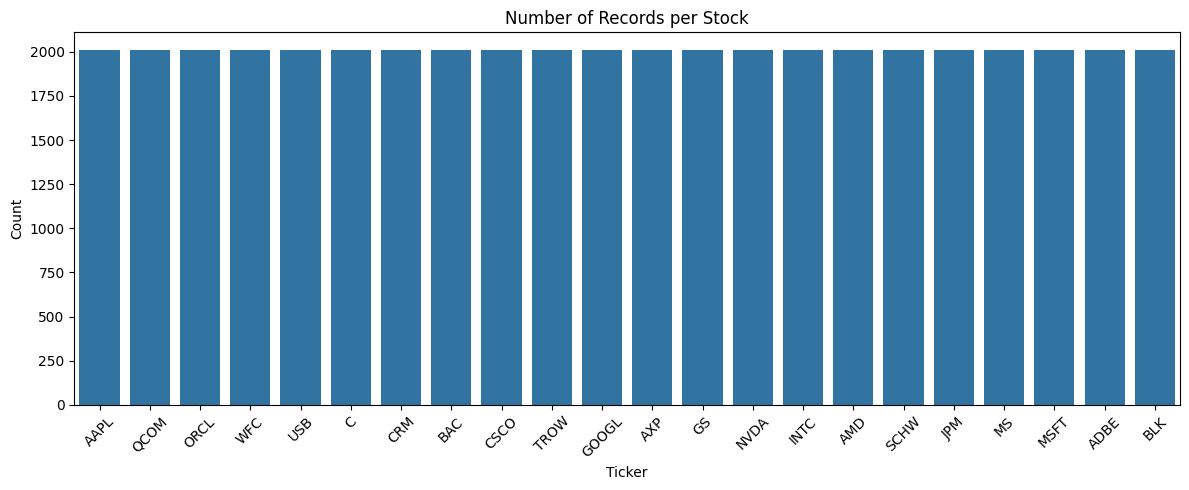

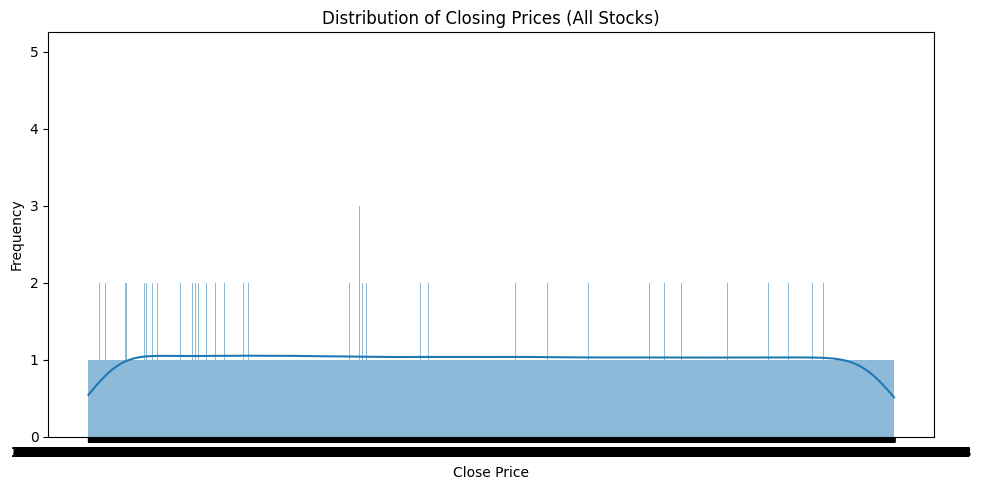

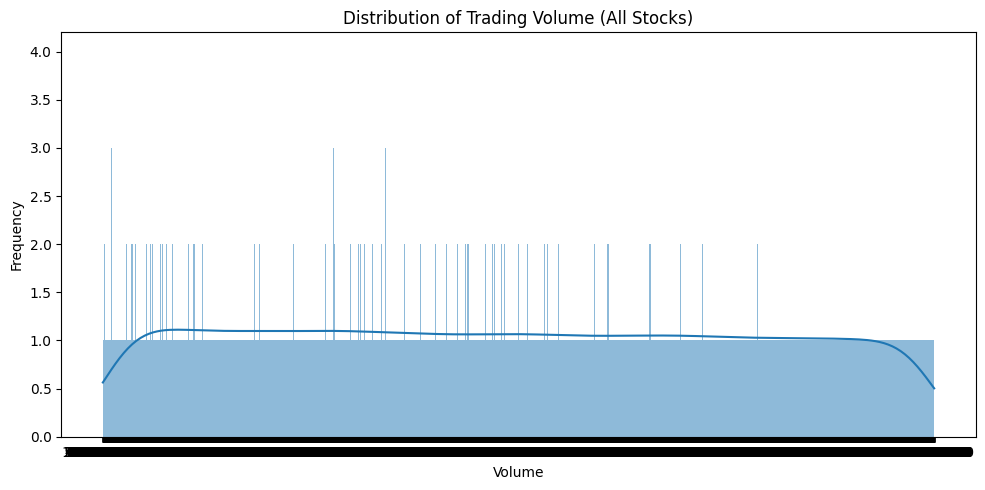

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean
df = pd.read_csv('final_daily_stocks_cleaned.csv')
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# 1. Number of Records per Stock
plt.figure(figsize=(12, 5))
stock_counts = df['ticker'].value_counts()
sns.barplot(x=stock_counts.index, y=stock_counts.values)
plt.title('Number of Records per Stock')
plt.xlabel('Ticker')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Closing Price Distribution (All Stocks Combined)
plt.figure(figsize=(10, 5))
sns.histplot(df['Close'], bins=100, kde=True)
plt.title('Distribution of Closing Prices (All Stocks)')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3. Volume Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Volume'], bins=100, kde=True)
plt.title('Distribution of Trading Volume (All Stocks)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd

# Load the cleaned stock data
df = pd.read_csv("final_daily_stocks_cleaned.csv")

# Sort by ticker and date
df = df.sort_values(by=["ticker", "Date"]).reset_index(drop=True)

# Container for all labeled groups
labeled_dfs = []

# Process each ticker
for ticker, group in df.groupby("ticker"):
    group = group.sort_values(by="Date").reset_index(drop=True)
    
    if len(group) < 2:
        continue  # not enough rows to create label

    # Compute 1-day ahead trend: 1 if Close[t+1] > Close[t], else 0
    trend = (group["Close"].shift(-1) > group["Close"]).astype(int)
    group["Trend"] = trend

    # Drop last row (cannot have label)
    group = group.iloc[:-1].reset_index(drop=True)

    labeled_dfs.append(group)

# Combine all tickers
df_labeled = pd.concat(labeled_dfs, ignore_index=True)

# Save result
df_labeled.to_csv("labeled_final_daily_stocks_v2.csv", index=False)

# Check
print("✅ Step 1 updated: Single-day trend label added.")
print("Tickers labeled:", df_labeled['ticker'].nunique())
print("Shape:", df_labeled.shape)


✅ Step 1 updated: Single-day trend label added.
Tickers labeled: 22
Shape: (44198, 9)


In [20]:
import pandas as pd

# Load labeled data with 1-day trend
df = pd.read_csv("labeled_final_daily_stocks_v2.csv")

# Generate mapping
unique_tickers = sorted(df['ticker'].unique())
ticker_to_id = {ticker: idx for idx, ticker in enumerate(unique_tickers)}

# Add ticker_id column
df['ticker_id'] = df['ticker'].map(ticker_to_id)

# Save updated file
df.to_csv("labeled_with_id_stocks_v2.csv", index=False)

# Save mapping
mapping_df = pd.DataFrame({
    'ticker': list(ticker_to_id.keys()),
    'ticker_id': list(ticker_to_id.values())
})
mapping_df.to_csv("ticker_mapping.csv", index=False)

print("✅ Step 2 complete: ticker_id added and mapping saved.")


✅ Step 2 complete: ticker_id added and mapping saved.


In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load file with labels and ticker_id
df = pd.read_csv("labeled_with_id_stocks_v2.csv")

# Columns to normalize
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']

# Normalize per ticker
def normalize_group(group):
    scaler = MinMaxScaler()
    group[columns_to_scale] = scaler.fit_transform(group[columns_to_scale])
    return group

df_normalized = df.groupby('ticker', group_keys=False).apply(normalize_group)

# Save normalized file
df_normalized.to_csv("normalized_labeled_stocks_v2.csv", index=False)

print("✅ Step 3 complete: Data normalized per ticker.")


✅ Step 3 complete: Data normalized per ticker.


In [25]:
import pandas as pd

# Load normalized data
df = pd.read_csv("labeled_with_id_stocks_v2.csv")

# Ensure proper sorting
df = df.sort_values(by=["ticker", "Date"]).reset_index(drop=True)

train_val_rows = []
test_rows = []

# Split last 5 rows per ticker as test
for ticker, group in df.groupby("ticker"):
    group = group.sort_values(by="Date")
    if len(group) <= 5:
        continue
    train_val_rows.append(group.iloc[:-5])
    test_rows.append(group.iloc[-5:])

# Combine
df_train_val = pd.concat(train_val_rows).reset_index(drop=True)
df_test = pd.concat(test_rows).reset_index(drop=True)

# Save splits
df_train_val.to_csv("train_val_v2.csv", index=False)
df_test.to_csv("test_v2.csv", index=False)

print("✅ Step 4 complete: Time-based split done.")
print(f"Train/Val shape: {df_train_val.shape}, Test shape: {df_test.shape}")


✅ Step 4 complete: Time-based split done.
Train/Val shape: (44088, 10), Test shape: (110, 10)


In [ ]:
import pandas as pd
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

# ============ HYPERPARAMETERS ============
INPUT_WINDOW = 200
BATCH_SIZE = 64
EPOCHS = 50
LR = 0.001
EMBEDDING_DIM = 16
HIDDEN_DIM = 64
FEATURE_COLS = ['Open', 'High', 'Low', 'Close', 'Volume']

# ============ LOAD RAW DATA ============
df = pd.read_csv("train_val_v2.csv")
df = df.sort_values(by=["ticker", "Date"]).reset_index(drop=True)

# ============ WINDOWED DATASET ============
class StockDataset(Dataset):
    def __init__(self, df, input_window):
        self.samples = []

        for _, group in df.groupby("ticker"):
            features = group[FEATURE_COLS].values
            labels = group["Trend"].values
            ticker_id = group["ticker_id"].iloc[0]

            for i in range(len(group) - input_window):
                x = features[i:i+input_window]
                y = labels[i+input_window]  # predict 1-day ahead trend
                self.samples.append((x, y, ticker_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y, ticker_id = self.samples[idx]
        return {
            "x": torch.tensor(x, dtype=torch.float32),
            "y": torch.tensor([y], dtype=torch.float32),
            "ticker_id": torch.tensor(ticker_id, dtype=torch.long)
        }

# ============ CREATE DATASETS ============
full_dataset = StockDataset(df, INPUT_WINDOW)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# ============ MODEL ============
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, num_tickers):
        super().__init__()
        self.embedding = nn.Embedding(num_tickers, embedding_dim)
        self.lstm = nn.LSTM(input_dim + embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, ticker_id):
        embed = self.embedding(ticker_id).unsqueeze(1).repeat(1, x.size(1), 1)
        x = torch.cat([x, embed], dim=2)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]  # last time step
        return self.fc(out)  # raw logit

# ============ TRAIN SETUP ============
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_tickers = df["ticker_id"].nunique()

model = LSTMModel(
    input_dim=len(FEATURE_COLS),
    hidden_dim=HIDDEN_DIM,
    embedding_dim=EMBEDDING_DIM,
    num_tickers=num_tickers
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_val_loss = float("inf")

# ============ TRAIN LOOP ============
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_correct = 0
    total_train = 0

    for batch in train_loader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        ticker_id = batch["ticker_id"].to(device)

        optimizer.zero_grad()
        output = model(x, ticker_id)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.sigmoid(output) > 0.5
        train_correct += (preds == y.bool()).sum().item()
        total_train += y.size(0)

    model.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            ticker_id = batch["ticker_id"].to(device)

            output = model(x, ticker_id)
            loss = criterion(output, y)
            val_loss += loss.item()

            preds = torch.sigmoid(output) > 0.5
            val_correct += (preds == y.bool()).sum().item()
            total_val += y.size(0)

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_acc = train_correct / total_train
    val_acc = val_correct / total_val

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("✔️ Saved best model")

print("✅ Training complete. Best model saved as best_model.pt")


In [28]:
import pandas as pd
import torch
from torch import nn

# Load both train and test
df_train = pd.read_csv("train_val_v2.csv")
df_test = pd.read_csv("test_v2.csv")

# Combine
df_full = pd.concat([df_train, df_test], ignore_index=True)
df_full = df_full.sort_values(by=["ticker", "Date"]).reset_index(drop=True)

# Constants
INPUT_WINDOW = 90
FEATURE_COLS = ['Open', 'High', 'Low', 'Close', 'Volume']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model definition
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, num_tickers):
        super().__init__()
        self.embedding = nn.Embedding(num_tickers, embedding_dim)
        self.lstm = nn.LSTM(input_dim + embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, ticker_id):
        embed = self.embedding(ticker_id).unsqueeze(1).repeat(1, x.size(1), 1)
        x = torch.cat([x, embed], dim=2)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        return self.fc(out)

# Load model
num_tickers = df_full['ticker_id'].nunique()

model = LSTMModel(
    input_dim=len(FEATURE_COLS),
    hidden_dim=64,
    embedding_dim=16,
    num_tickers=num_tickers
).to(device)

model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Predict next-day trend for each ticker
results = []

for ticker, group in df_full.groupby("ticker"):
    group = group.sort_values(by="Date").reset_index(drop=True)

    if len(group) < INPUT_WINDOW:
        print(f"❗ Skipping {ticker}, not enough rows")
        continue

    x = group[FEATURE_COLS].values[-INPUT_WINDOW:]
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

    ticker_id = group["ticker_id"].iloc[-1]
    ticker_tensor = torch.tensor([ticker_id], dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(x_tensor, ticker_tensor)
        score = torch.sigmoid(output).item()

    results.append((ticker, score))

# Show predictions
print("\n📊 Final Predictions (Realistic Input: Last 90 Days)")
for ticker, score in results:
    print(f"{ticker.upper():<8} → Score: {score:.4f} → {'UP' if score >= 0.5 else 'DOWN'}")



📊 Final Predictions (Realistic Input: Last 90 Days)
AAPL     → Score: 0.5140 → UP
ADBE     → Score: 0.5140 → UP
AMD      → Score: 0.5140 → UP
AXP      → Score: 0.5140 → UP
BAC      → Score: 0.5140 → UP
BLK      → Score: 0.5140 → UP
C        → Score: 0.5140 → UP
CRM      → Score: 0.5140 → UP
CSCO     → Score: 0.5140 → UP
GOOGL    → Score: 0.5140 → UP
GS       → Score: 0.5140 → UP
INTC     → Score: 0.5140 → UP
JPM      → Score: 0.5140 → UP
MS       → Score: 0.5140 → UP
MSFT     → Score: 0.5140 → UP
NVDA     → Score: 0.5140 → UP
ORCL     → Score: 0.5140 → UP
QCOM     → Score: 0.5140 → UP
SCHW     → Score: 0.5140 → UP
TROW     → Score: 0.5140 → UP
USB      → Score: 0.5140 → UP
WFC      → Score: 0.5140 → UP


C:\Users\HP\AppData\Local\Temp\ipykernel_3808\3046068255.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))
